# Assessment of the effect of climate change on sea ice using satellite sea ice concentration products

## User question
Can we see the effect of climate change using satellite sea ice concentration products?

## Methods
We use the [sea ice concentration dataset](https://cds.climate.copernicus.eu/cdsapp#!/dataset/satellite-sea-ice-concentration?tab=overview), which has three products:
- EUMETSAT OSI SAF CDR (1979-2015)
- ESA CCI (2003-2017)
- EUMETSAT OSI SAF ICDR (2016-2023)

For each product, we create time series of the sea ice extent and area. The seasonal cycles are plotted by year to see if it is changing with time. In addition the yearly minima and maxima of these are computed and plotted to see if they are changing with time.

## Summary
The Arctic sea ice extent and area show a clear downward trend in the 1979-2015 period covered by EUMETSAT OSI SAF CDR. The minimum extent shows a greater drop (3.5 million km$^2$) than the maximum (2.5 million km$^2$), although the maximum extent has a steadier drop. From the ESA CCI product and the EUMETSAT OSI SAF ICDR products, there are signs the drops could be continuing although it is difficult to draw any conclusion about this due to the shorter temporal interval (2015-2023).

On the other hand, the Antarctic sea ice minima and maxima in extent show an upward trend in the 1979-2015 period covered by EUMETSAT OSI SAF CDR. However, there is quite a lot of spread in these values. There are signs that both have been starting to drop in recent years, with 2017 and 2023 having notably low minima in extent, but again the shorter time interval (2015-2023) since then again makes it difficult to draw any conclusion about this.

## Code

### Import libraries

In [1]:
import warnings

import os
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import matplotlib.dates as mdates
import xarray as xr
from c3s_eqc_automatic_quality_control import diagnostics, download
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

plt.style.use("seaborn-v0_8-notebook")
warnings.filterwarnings("ignore", module="cf_xarray")

### Set parameters

In [2]:
# Time
start_year = 1979
stop_year = 2023

# Conc threshold for calculating extent
sic_threshold = 15

### Define request

In [3]:
collection_id = 'satellite-sea-ice-concentration'

conc_request = {
    "cdr_type": "cdr",
    "variable": "all",
    "version": "v2",
    "temporal_aggregation": "daily",
}

request_dict = {
    # CDR
    "EUMETSAT-OSI-SAF (CDR)": download.update_request_date(
        conc_request | {"origin": "EUMETSAT OSI SAF", "sensor": "ssmis"},
        start=f"{max(start_year, 1979)}-01",
        stop=f"{min(stop_year, 2015)}-12",
        stringify_dates=True,
    ),
    # interim CDR for later years
    "EUMETSAT-OSI-SAF (ICDR)": download.update_request_date(
        conc_request | {"cdr_type": "icdr", "origin": "EUMETSAT OSI SAF", "sensor": "ssmis"},
        start=f"{max(start_year, 2016)}-01",
        stop=f"{min(stop_year, 2023)}-12",
        stringify_dates=True,
    ),
    # only CDR available for ESA-CCI
    "ESA-CCI (CDR)": download.update_request_date(
        conc_request | {"origin": "ESA CCI", "sensor": "amsr"},
        start=f"{max(start_year, 2002)}-01",
        stop=f"{min(stop_year, 2017)}-12",
        stringify_dates=True,
    ),
}

### Define function to cache

In [4]:
def compute_siconc_time_series(ds, sic_threshold):
    ds = ds.convert_calendar("standard", align_on="date")

    # grid cell area of sea ice edge grid
    dims = ("xc", "yc")
    dx = np.abs(np.diff(ds[dims[0]][:2].values))[0]
    grid_cell_area = (dx ** 2) * 1.0e-6  # 10^6 km2

    # get sea ice concentration and convert to ice/water classification
    sic = ds.cf["sea_ice_area_fraction"]
    sic_error = ds.cf["sea_ice_area_fraction standard_error"]
    if sic.attrs.get("units", "") == "(0 - 1)":
        sic *= 100
        sic_error *= 100

    # compute extent
    dataarrays = {}
    sic_class = xr.where(sic >= sic_threshold, 2, 1) # 1 = open water, 2 = ice
    dataarrays["extent"] = grid_cell_area * (sic_class - 1).sum(dim=dims)
    dataarrays["extent"].attrs = {
        "standard_name": "sea_ice_extent",
        "units": "$10^6$km$^2$",
        "long_name": "Sea ice extent",
    }

    # compute area
    dataarrays["area"] = grid_cell_area * .01 * sic.sum(dim=dims)
    dataarrays["area"].attrs = {
        "standard_name": "sea_ice_area",
        "units": "$10^6$km$^2$",
        "long_name": "Sea ice area",
    }

    # compute RMS error
    dataarrays["rms_error"] = np.sqrt((sic_error ** 2).mean(dim=dims))
    dataarrays["rms_error"].attrs = {
        "standard_name": "root_mean_square sea_ice_area_fraction standard_error",
        "units": "$10^6$km$^2$",
        "long_name": "Root mean square sea ice area fraction standard error",
    }

    return xr.Dataset(dataarrays)

### Code to make time series plots against day of year

In [5]:
def rearrange_year_vs_dayofyear(ds):
    new_dims = ("year", "dayofyear")
    ds = ds.convert_calendar("noleap")
    ds = ds.assign_coords(
        {dim: ("time", getattr(ds["time"].dt, dim).values) for dim in new_dims}
    )
    return ds.set_index(time=new_dims).unstack("time")


def make_subplot(ax, ds_doy, vname, color_map):
    num_years = len(ds_doy.year)
    for i,year in enumerate(ds_doy.year):
        da = ds_doy.sel(year=year)[vname].squeeze()
        ax.plot(da.dayofyear, da.values, color=color_map(i/(num_years-1)), label=year.item())


def plot_against_dayofyear(ds, cmap = "viridis"):
    num_years = len(ds.year)
    color_map = plt.get_cmap(cmap, num_years)

    var_names = ["extent", "area"]
    fig, axs = plt.subplots(len(var_names), 1, sharex=True)
    for vname, ax in zip(var_names, axs.flatten()):
        make_subplot(ax, ds, vname, color_map)
        ax.set_ylabel(f"Sea ice {vname} [{ds[vname].units}]")

    ax.xaxis.set_major_formatter(mdates.DateFormatter("%d %b"))
    ax.xaxis.set_tick_params(rotation=45)
    cbar = fig.colorbar(
        plt.cm.ScalarMappable(
            cmap=cmap,
            norm=plt.Normalize(vmin=min(ds.year), vmax=max(ds.year)),
        ),
        ax=axs.ravel().tolist(),
    )
    cbar.set_label('Year')

### Code to make time series plots of yearly minima and maxima

In [6]:
def full_year_only_resample(ds, reduction, sel_dict=None):
    """
    Calculate yearly reduction eg to get the yearly min or max of a time series
    
    Parameters
    ----------
    ds : xr.Dataset
    reduction : str
        eg min or max

    Returns
    -------
    ds_reduced : xr.Dataset
        resampled time series
    """
    if sel_dict:
        ds = ds.sel(sel_dict)
    year_mask = ds["time"].resample(time="YE").count() > 150
    return getattr(ds.resample(time="YE"), reduction)(), year_mask


def get_yearly_min_max(ds, **kwargs):
    ds1 = ds.drop_vars(["rms_error"])
    data = {}
    for reduction in ["min", "max"]:
        ds2, year_mask = full_year_only_resample(ds1, reduction, **kwargs)
        data["year_mask"] = xr.DataArray(
            year_mask.values, coords={"year": ds2.time.dt.year.values},
            attrs={"description": "True if year has sufficient observations"})
        for var_name in ds2.data_vars:
            da = ds2[var_name]
            atts = da.attrs
            atts["standard_name"] = f"{reduction}_{atts['standard_name']}"
            atts["long_name"] = f"{reduction.capitalize()}imum {atts['long_name'][0].lower()}{atts['long_name'][1:]}"
            data[f"{reduction}_{var_name}"] = xr.DataArray(
                da.values, attrs=atts, coords={"year": ds2.time.dt.year.values, "region": ds2.region.values})
    return xr.Dataset(data)


def plot_yearly_extremes(datasets, region="northern_hemisphere", var_name="min_extent"):
    fig, ax = plt.subplots(1, 1)
    for product, ds in datasets.items():
        year_mask = ds["year_mask"]
        if product == "ESA-CCI (CDR)":
            if var_name == "min_extent":
                # make sure 2012 record Arctic minimum is included (exclude Antarctic minimum)
                year_mask[ds.year.values == 2012] = (region == "northern_hemisphere")
                # exclude Antarctic minimum in 2002
                year_mask[ds.year.values == 2002] = (region == "northern_hemisphere")
                # include Antarctic minimum in 2017
                year_mask[ds.year.values == 2017] = (region == "southern_hemisphere")

            if var_name == "max_extent":
                # include Arctic maximum in 2017
                year_mask[ds.year.values == 2017] = (region == "northern_hemisphere")
                # make sure 2012 Antarctic maximum is included (exclude Arctic maximum)
                year_mask[ds.year.values == 2012] = (region == "southern_hemisphere")
                # exclude Arctic maximum in 2002
                year_mask[ds.year.values == 2002] = (region == "southern_hemisphere")

        ds2 = ds.sel(region=region).where(year_mask, drop=True)
        da = ds2[var_name]
        ax.plot(da.year, da.values, '^-', label=product)
    ax.set_ylabel(f"{da.attrs['long_name']} [{da.attrs['units']}]")
    ax.set_xlabel(f"Year")
    ax.xaxis.set_minor_locator(MultipleLocator(5))
    ax.tick_params(axis='x', which='minor', top=False)
    ax.grid(axis='x', which='both', linestyle=':')
    ax.grid(axis='y', which='both', linestyle=':')

    _ = ax.legend()

### Download and transform

In [7]:
kwargs = {
    # Parameters to speed up IO
    # "combine": "nested",
    # "data_vars": "minimal",
    "coords": "minimal",
    "compat": "override",
    "drop_variables": (
        "raw_ice_conc_values",
        "smearing_standard_error",
        "algorithm_standard_error",
        "status_flag",
    ),
}

datasets_diagnostics = {}
datasets = []
for product, requests in request_dict.items():
    for region in [
        "northern_hemisphere",
        "southern_hemisphere",
    ]:
        print(f"{product = }, {region = }")
        regional_requests = [request | {"region": region} for request in requests]
        ds = download.download_and_transform(
            collection_id, regional_requests,
            transform_func=compute_siconc_time_series,
            transform_func_kwargs={"sic_threshold": sic_threshold},
            chunks={"year": 1},
            **kwargs,
        )
        datasets.append(ds.expand_dims(region=[region]).compute())
    datasets_diagnostics[product] = xr.concat(datasets, "region")
    datasets = []

product = 'EUMETSAT-OSI-SAF (CDR)', region = 'northern_hemisphere'


100%|██████████| 37/37 [00:03<00:00, 11.92it/s]


product = 'EUMETSAT-OSI-SAF (CDR)', region = 'southern_hemisphere'


100%|██████████| 37/37 [00:02<00:00, 15.93it/s]


product = 'EUMETSAT-OSI-SAF (ICDR)', region = 'northern_hemisphere'


100%|██████████| 8/8 [00:00<00:00, 18.86it/s]


product = 'EUMETSAT-OSI-SAF (ICDR)', region = 'southern_hemisphere'


100%|██████████| 8/8 [00:00<00:00, 19.13it/s]


product = 'ESA-CCI (CDR)', region = 'northern_hemisphere'


100%|██████████| 16/16 [00:01<00:00, 15.61it/s]


product = 'ESA-CCI (CDR)', region = 'southern_hemisphere'


100%|██████████| 16/16 [00:00<00:00, 19.26it/s]


## Sort the datasets out for plotting

In [8]:
datasets_diagnostics_rearranged = {}
datasets_diagnostics_minmax = {}
for product in request_dict:
    datasets_diagnostics_rearranged[product] = rearrange_year_vs_dayofyear(datasets_diagnostics[product])
    datasets_diagnostics_minmax[product] = get_yearly_min_max(datasets_diagnostics[product])

# Arctic sea ice

Below we plot the daily Arctic sea ice extent from 1979 to 2015 from the EUMETSAT-OSI-SAF CDR product. This is the product spanning the longest period. Clearly later years have lower extent than earlier ones with 2012 having the lowest minimum extent in this period. The minimum (September) extents show a much wider spread than those at other times of the year.

We also plot the sea ice area which follows a similar pattern but is about 2.5 million km$^2$ lower than the extent.

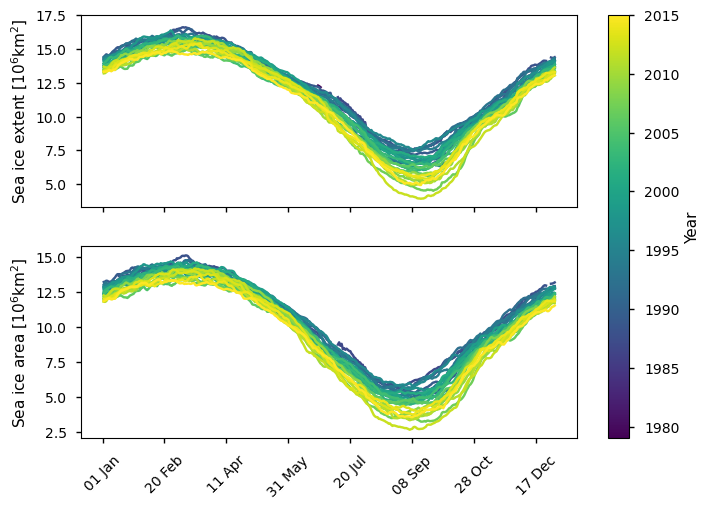

In [9]:
plot_against_dayofyear(datasets_diagnostics_rearranged["EUMETSAT-OSI-SAF (CDR)"].sel(region="northern_hemisphere"))

Below we plot the daily Arctic sea ice extent from 2002 to 2017 from the ESA-CCI CDR product. This is the product spanning the longest period. Like with the previous product earlier years generally
have higher extents. Again the year with the lowest minima in this product is 2012, with 2007 and 2016 being notable lows. The years with the lowest maxima are 2017 and 2016.

We also plot the sea ice area which follows a similar pattern but is about 2.5 million km$^2$ lower than the extent.

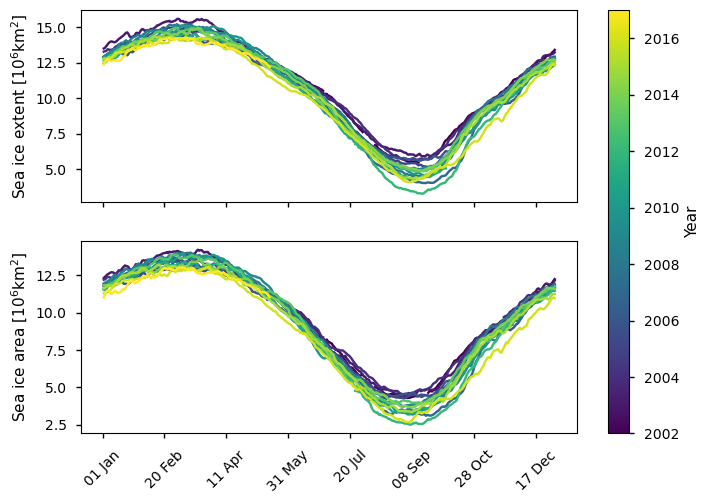

In [10]:
plot_against_dayofyear(datasets_diagnostics_rearranged["ESA-CCI (CDR)"].sel(region="northern_hemisphere"))

Below we plot the daily Arctic sea ice extent from 2016 to 2023 from the EUMETSAT-OSI-SAF ICDR product. This is the product spanning the shortest period and there is no clear pattern present in it. The year with the lowest minima in this product is 2020.

We also plot the sea ice area which follows a similar pattern but is about 2.5 million km$^2$ lower than the extent.

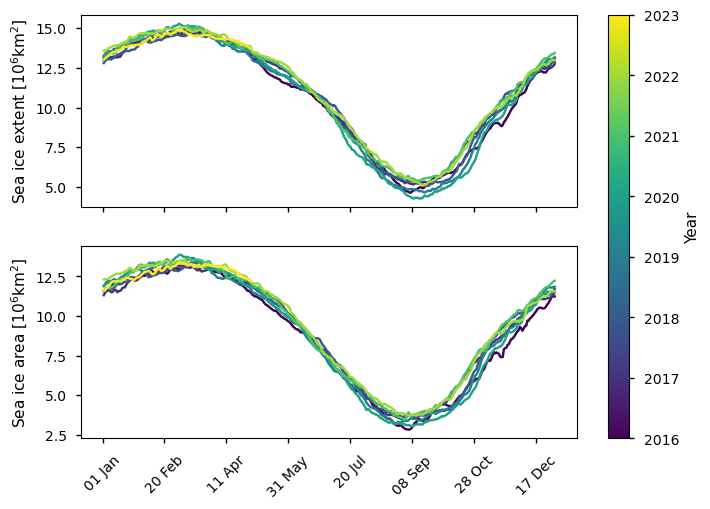

In [11]:
plot_against_dayofyear(datasets_diagnostics_rearranged["EUMETSAT-OSI-SAF (ICDR)"].sel(region="northern_hemisphere"))

Below we plot the Arctic yearly minima in extent for all the products. There is a clear downward trend in the EUMETSAT-OSI-SAF CDR product, which spans the longest period. The drop is about 3 million km$^2$ over the 20-year period from 1995 to 2015. There is a slower drop in the previous years, but it is less clear. This product has higher values than the ESA-CCI product illustrating the possible magnitude of the uncertainty in the products, which could be around 0.5 million km$^2$. The EUMETSAT-OSI-SAF ICDR product is consistent with the CDR product, but it covers too short a time period to see any reliable trend.

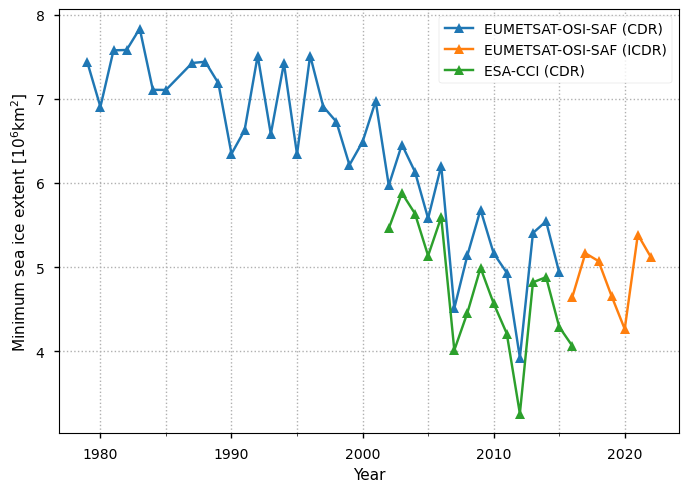

In [12]:
plot_yearly_extremes(datasets_diagnostics_minmax, var_name="min_extent")

Below we plot the Arctic yearly maxima in extent for all the products. There is a clear downward trend in the EUMETSAT-OSI-SAF CDR and ICDR products, which together span the full period. The drop is about 2 million km$^2$ over the 44-year period from 1979 to 2023, which while lower than for the yearly minima is more steady. The EUMETSAT-OSI-SAF products again have higher values than the ESA-CCI product, again by around 0.5 million km$^2$. Note that notably low sea ice minima (eg 2007, 2012) are preceded by notably low maxima (eg 2006, 2011).

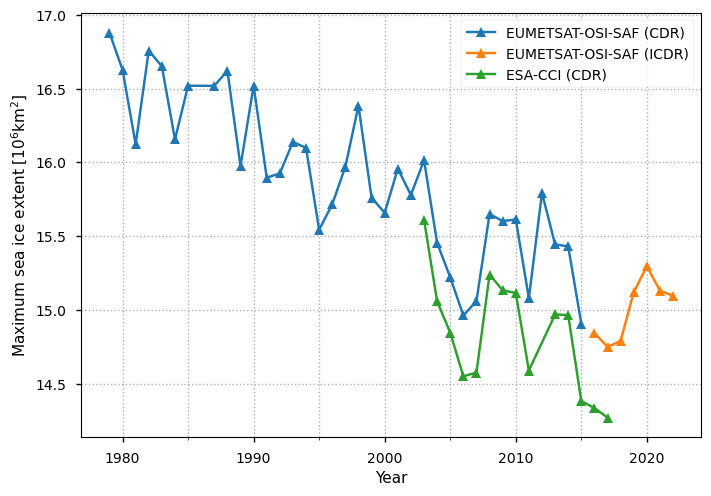

In [13]:
plot_yearly_extremes(datasets_diagnostics_minmax, var_name="max_extent")

# Antarctic sea ice

Below we plot the daily Antarctic sea ice extent from 1979 to 2015 from the EUMETSAT-OSI-SAF CDR product. This is the product spanning the longest period.The progression with year is not as clear as for the Arctic, and unlike in the Arctic many later years are among those with higher extents. Again unlike the Arctic, which had a higher spread around September, the spread of the extents is similar throughout the year.

We also plot the sea ice area which follows a similar pattern but is about 4.5 - 5 million km$^2$ lower than the extent.

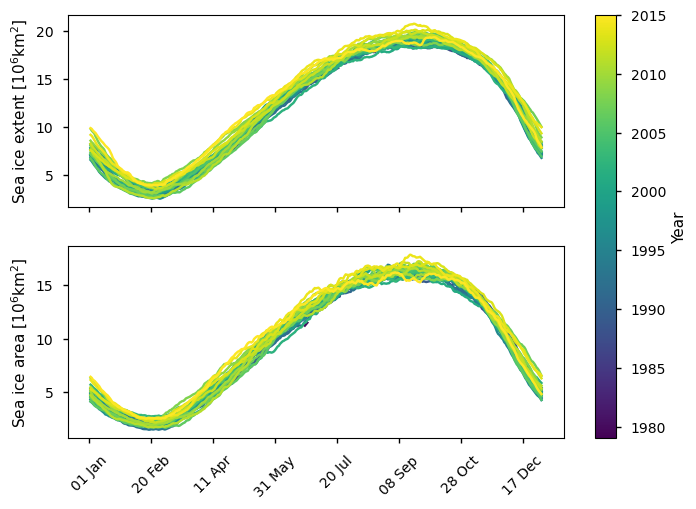

In [14]:
plot_against_dayofyear(datasets_diagnostics_rearranged["EUMETSAT-OSI-SAF (CDR)"].sel(region='southern_hemisphere'))

Below we plot the daily Antarctic sea ice extent from 2002 to 2017 from the ESA-CCI CDR product. This product has a bit more spread around the time of the sea ice minimum (March) compared to the rest of the year. The year with the lowest minimum is 2017.

We also plot the sea ice area which follows a similar pattern but is about 4.5 - 5 million km$^2$ lower than the extent.

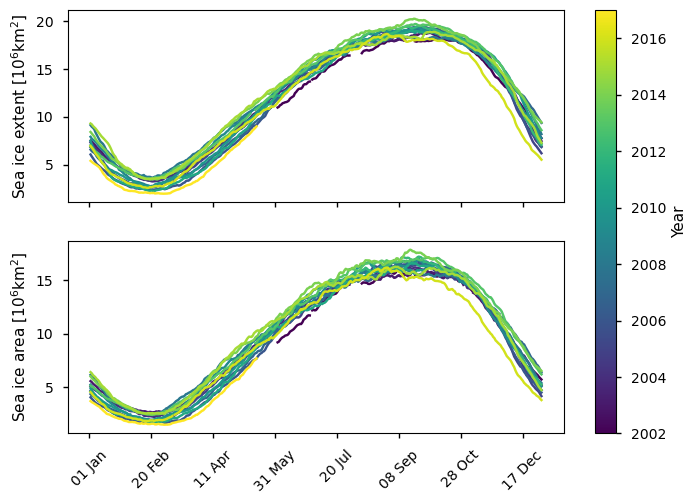

In [15]:
plot_against_dayofyear(datasets_diagnostics_rearranged["ESA-CCI (CDR)"].sel(region='southern_hemisphere'))

Below we plot the daily Antarctic sea ice extent from 2016 to 2023 from the EUMETSAT-OSI-SAF ICDR product. This is the product spanning the shortest period and there is no clear pattern present in it. The year with the lowest minima in this product is 2023.

We also plot the sea ice area which follows a similar pattern but is about 4.5 - 5 million km$^2$ lower than the extent.

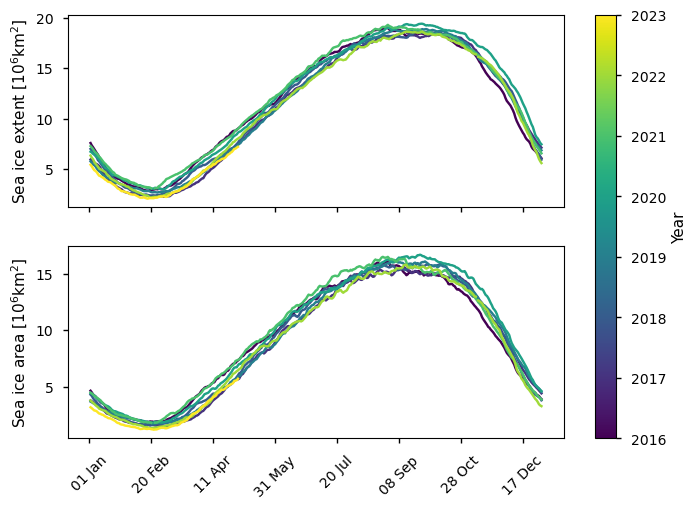

In [16]:
plot_against_dayofyear(datasets_diagnostics_rearranged["EUMETSAT-OSI-SAF (ICDR)"].sel(region='southern_hemisphere'))

Below we plot the Antarctic yearly minima in extent for all the products. There is quite a spread and there seems to be a moderate upward trend up to about 2015 when the EUMETSAT-OSI-SAF CDR product ends.
However the EUMETSAT-OSI-SAF ICDR which covers the later years has much lower minimum extents. It is difficult to say if this is physical or due to the change in product, especially as the ESA-CCI product finishes in 2017. Having said this, the ESA-CCI product also shows a moderate downward trend although it has a very large spread.

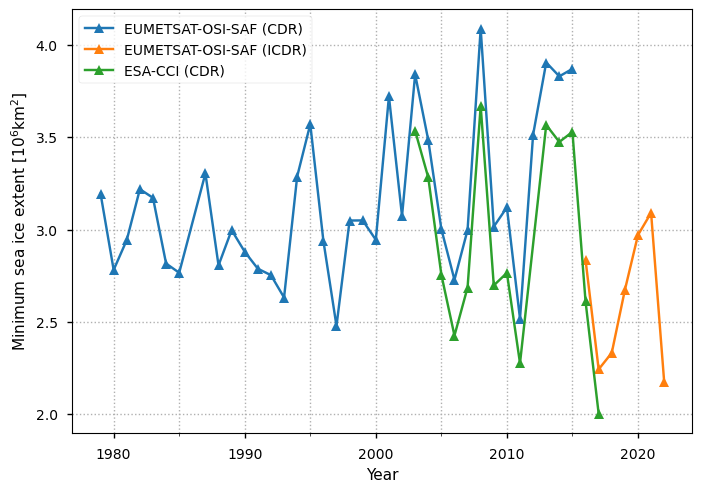

In [17]:
plot_yearly_extremes(datasets_diagnostics_minmax, region="southern_hemisphere", var_name="min_extent")

Below we plot the Antarctic yearly maxima in extent for all the products. There is less spread than for the minima, and it is stable up to about 2000. After then there also seems to be a moderate upward trend up to about 2015.
However the EUMETSAT-OSI-SAF ICDR product again has much lower maximum extents. It is difficult to say if this is physical or due to the change in product, especially as the ESA-CCI product finishes in 2017. The ESA-CCI product also shows a moderate upward trend although it has a very large spread, and its later years are consistent with the drop shown by the EUMETSAT-OSI-SAF ICDR product.

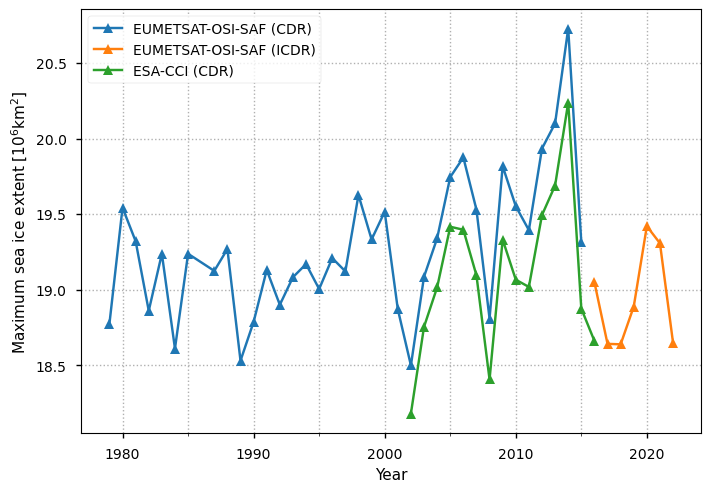

In [18]:
plot_yearly_extremes(datasets_diagnostics_minmax, region="southern_hemisphere", var_name="max_extent")